# **Purpose of this project**

Main purpose of this project is to develop a smart pricing tool for the hosts of Airbnb, in order to maximize their profit. Moreover, we create a clustering (unsupervised) model to help customers get similar recommendations.

For the **pricing tool**,  our aim is to create an algorithm model that does not stand as a predictor of flat prices but rather as a pricing tool for profit optimization. Underlying idea is the fact that we can optimize the pricing ML pipeline by specific-purpose data preprocessing and feature engineering. Through proper "demand analysis" we are able to locate and exclude ghost-flats (flats with very low occupancy rate through-out the year) from our dataset, leading to a significant boost of the model's performace. Model not only performs better but also suggests prices that will actually benefit the host. Moreover, we enhance the features of our dataset by including the flats distance from famous NY tourist attractions as we believe that there is indeed an inverse relation between the mentioned distance and the price. 

For the ML pipeline of the pricing tool, we create a **"Meta holdout scheme with OOF meta-features"** architecture. Such implementation proves to be performing great on this data, since it is computationally and time efficient, while providing promising results.

For the recommendation tool, we use Principal Component Analysis followed by a K-Means unsupervised model. PCA is performed for a 95% variance. Analysis includes "Elbow theorem" and "Silhuette scores" plotting in order to find the optimum number of clusters. Both plots indicate that three is the best choice of number of clusters, achieving a silhuette score of 0.48.

**Structure of the project**:

*   Dataset brief description 
*   Data Visualization
*   Further analysis of distribution of the data
*   Demand Analysis
*   Feature engineering - Distance from NY attractions
*   Rooms recommendation (K-Means clustering)
*   Pricing optimization (Meta holdout scheme with OOF meta-features)

#Importing Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import datasets
from sklearn import metrics
from sklearn import cluster
from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from matplotlib.pyplot import figure
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
!pip install catboost
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics.cluster import silhouette_score
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth
from scipy.cluster.hierarchy import dendrogram, fcluster, cophenet, set_link_color_palette
from scipy.spatial.distance import squareform

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 64.8MB 48kB/s 


In [0]:
plt.style.use("default")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df=pd.read_csv("/content/drive/My Drive/AB_NYC_2019.csv")

##Some custom functions we will be using

**Memory Usage Reduction**

Before we continue, it will benefit us to have the memory reduction function and apply it to the dataset before training the ML algorithms.

In [0]:
# many thanks to https://www.kaggle.com/evilmind/memory-usage-reduction for the below function
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")

Seperating numerical / categorical columns

In [0]:
def categorical_numerical(df):
  columns=df.columns.tolist()
  num_columns = df._get_numeric_data().columns
  categorical_columns=list(set(columns) - set(num_columns))
  return num_columns,categorical_columns

# Brief description of the dataset

The table below shows that we have information regarding the host (columns: "id","host_id","host_name"), the location (columns: "neighbourhood_group","neighbourhood","latitude","longtitude"), the room type, the minimum nights that the room can be rent, reviews of the room (columns: "number_of_reviews","last_review","reviews_per_month"), the host listing and the availability of the room throughout the year. Moreover we have a brief description of each room under the column "name".

In [7]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


##Dropping unnecessery columns

In [0]:
df=df.drop(['name','host_id','host_name','last_review'], axis = 1) 

Now that we have a dataframe having only the needed feautures, we can proceed into exploring the data we will be working with.

##Searching for missing values and duplicates

Before we start plotting, we have to make sure we do not have any missing values.

In [0]:
df.isnull().sum()

id                                    0
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [0]:
df.loc[df['reviews_per_month'].isna()].number_of_reviews.describe()

count    10052.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: number_of_reviews, dtype: float64

All the NaN values of "reviews_per_month" occur for indexes where number_of_reviews of the room equal to zero. Which means that there are no reviews for these rooms. Hence, we can set "reviews_per_month"=0 for the NaN values

In [0]:
df["reviews_per_month"].fillna(0,inplace=True)

In [0]:
df.drop_duplicates(keep="first",inplace=True) 


Having established a solid dataset to work with, we can further look into the quality and the charasteristics of the data provided

#Exploratory Data Analysis

For the first part of our main analysis, it is essential that we understand the correlation between the different tables.

To start with, it is easily understood from the pie-chart that Manhattan and Brooklyn comprise the vast majority of Airbnb flats followed by Queens.

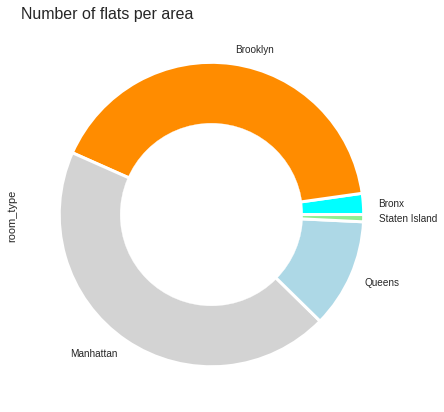

In [0]:
df.groupby("neighbourhood_group")["room_type"].count().plot.pie(figsize=(15,6), pctdistance=1.4,colors=['cyan','darkorange','lightgrey','lightblue','lightgreen'],
                                    wedgeprops={'linewidth':3, 'edgecolor':'white'})
# create circle for the center of the plot to make the pie look like a donut
my_circle = plt.Circle((0,0), 0.6, color='white')
# plot the donut chart
fig = plt.gcf()
fig.set_size_inches(7,7)
fig.gca().add_artist(my_circle)
plt.title("Number of flats per area",loc='left',fontsize=16)
plt.show()

We now want to examine the way price of rooms is distributed at these areas. The best way to do so, is by using a violin plot.

Major differences of the first two violin plots immediately catch the attention. While the lower adjacent value is almost the same, first quartile, median and third quartile of Manhattans’ violin plot are at vey higher values. Furthermore, the upper adjacent of Manhattans’ violin plot implies that Manhattan prices can get much higher than its median and third quartile.

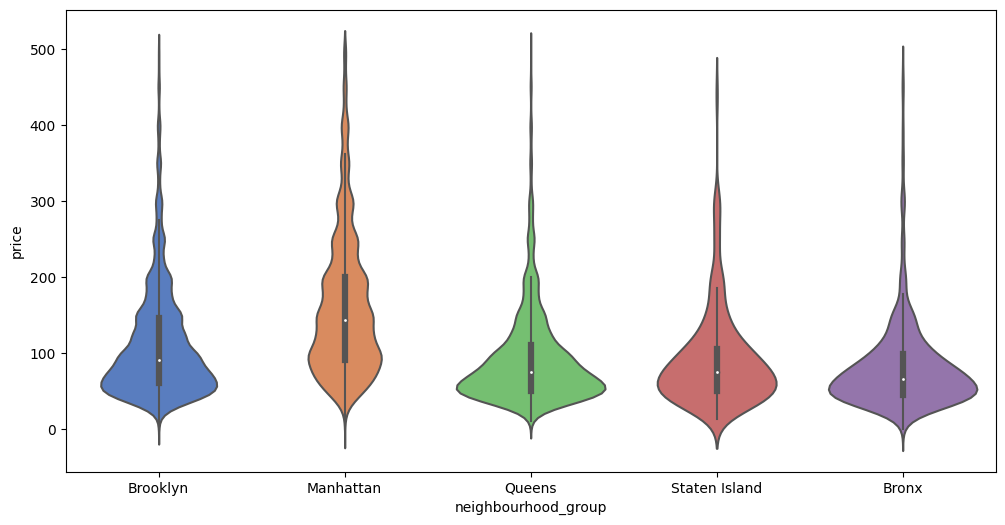

In [0]:
plt.style.use('default')
plt.figure(figsize=(12,6))
sns.violinplot(x='neighbourhood_group', y='price',data=df.loc[df["price"]<500],palette="muted")

plt.show()

At this point, we could also have an insight of the average price per area.

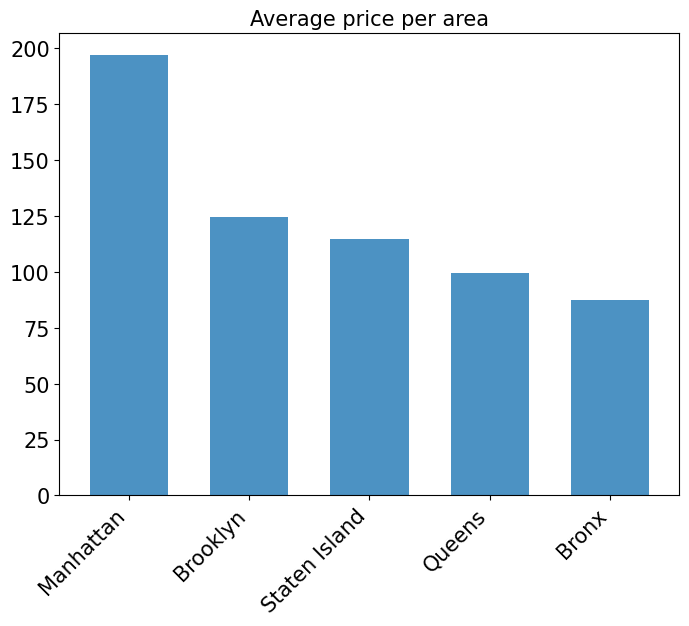

In [0]:
df.groupby(["neighbourhood_group"])["price"].mean().sort_values(ascending=False).plot(kind="bar", alpha=0.8,width=0.65,figsize=(8,6),fontsize=15)
plt.title('Average price per area',fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.xlabel("")
plt.show()

As expected, Manhattan has by far the most expensive Airbnb rooms followed by Brooklyn.

One more thing worth investigating is the room type for each area. For this case, using a grouped bar-chart allows us to easily make observations about differences inside a group.

Four out of five areas of New York have the private room as the preferred way of Airbnb accommodation, while the Shared Room comes last at all five areas.

Moreover, although Brooklyn has about the same number of apartments and private rooms, Manhattan has a much greater number of apartments/entire homes compared to private rooms. Manhattan is the only area of New York where Airbnb hosts prefer to provide apartments over private rooms.

Manhattan has the highest prices and is also having a different strategy (hosts providing mainly entire houses instead of private rooms).

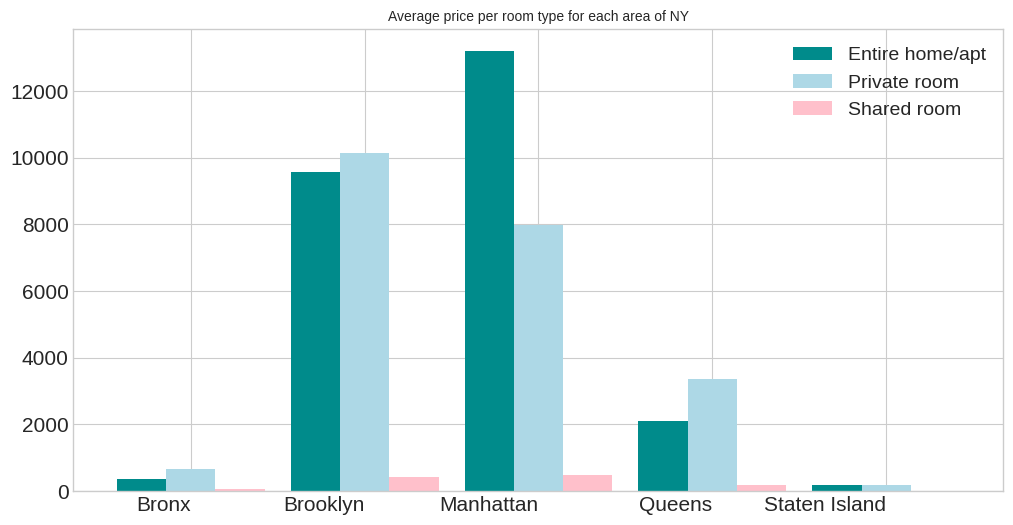

In [0]:
plt.style.use('seaborn-whitegrid')
df.groupby(["neighbourhood_group","room_type"])["room_type"].count().unstack().plot(kind="bar",width=0.85,figsize=(12,6),fontsize=15,color=["darkcyan","lightblue","pink"])
plt.legend(fontsize=14,loc='upper right')
plt.title('Average price per room type for each area of NY',fontsize=10)
plt.xticks(rotation=0, ha='right')
plt.xlabel("")
plt.show()

#Feature Engineering

Some of the numerical features have to be processed, as it is not meaningful to have more than 30 reviews per month for a room, or a minimum of 1250 nights for a stay. Through data visualization we can have a better picture of the distribution of these features.

In [0]:
df.drop(df[["latitude","longitude"]],axis=1).describe()

,id,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,1.901714e+07,152.720687,7.029962,23.274466,1.090910,7.143982,112.781327
std,1.098311e+07,240.154170,20.510550,44.550582,1.597283,32.952519,131.622289
min,2.539000e+03,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,9.471945e+06,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,1.967728e+07,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,2.915218e+07,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000
max,3.648724e+07,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


Moreover, since we want to make a smart pricing tool for Airbnb, we also have to trim the "price" feature, as the outliers such as $10000 would not stand as a reasonable suggestion in any case, hence we decide to exclude them from the dataset.

Lets visually observe the distribution of these features.

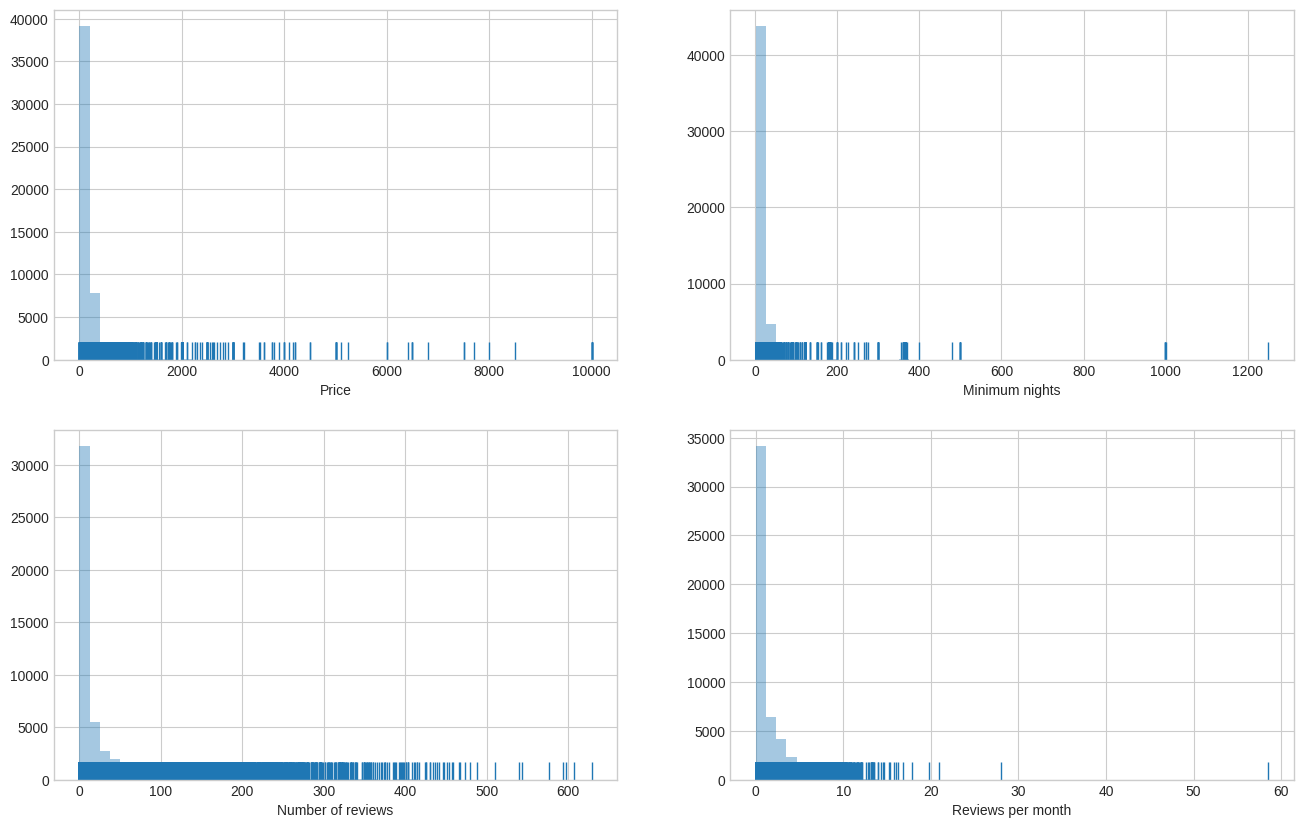

<Figure size 640x480 with 0 Axes>

In [0]:
fig = plt.figure(figsize=(16,10))
plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

sns.distplot(df["price"],ax=ax1,axlabel="Price",rug=True, kde=False)
sns.distplot(df["minimum_nights"],ax=ax2,axlabel="Minimum nights",rug=True, kde=False)
sns.distplot(df["number_of_reviews"],ax=ax3,axlabel="Number of reviews",rug=True, kde=False)
sns.distplot(df["reviews_per_month"],ax=ax4,axlabel="Reviews per month",rug=True, kde=False)


It appears that many of the feautures suffer from heavily uneven distribution which will later have an effect to our machine learning model. We will take out these outliers. 

More specifically: we will trim price for values over $600 per night, minimum nights for values over 300, number of reviews for over 365 (as it is a per year feature) and reviews per month over 31.

In [0]:
df=df[df["price"]<600]
df=df[df["minimum_nights"]<300]
df=df[df["number_of_reviews"]<=365]
df=df[df["reviews_per_month"]<=31]

Let's plot again and observe the distributions.

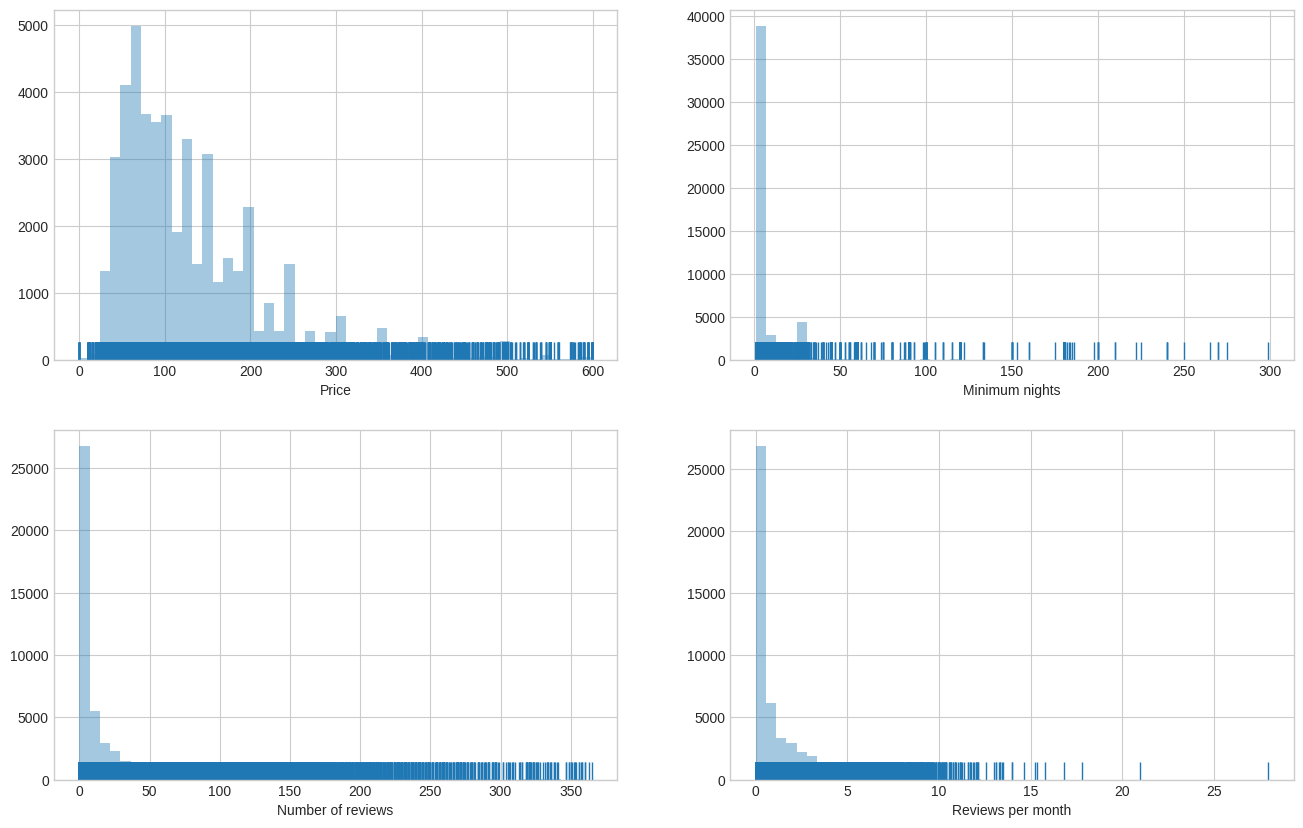

<Figure size 640x480 with 0 Axes>

In [0]:
fig = plt.figure(figsize=(16,10))
plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

sns.distplot(df["price"],ax=ax1,axlabel="Price",rug=True, kde=False)
sns.distplot(df["minimum_nights"],ax=ax2,axlabel="Minimum nights",rug=True, kde=False)
sns.distplot(df["number_of_reviews"],ax=ax3,axlabel="Number of reviews",rug=True, kde=False)
sns.distplot(df["reviews_per_month"],ax=ax4,axlabel="Reviews per month",rug=True, kde=False)

#Demand Analysis

One of the biggest issues with Airbnb is getting the occupancy rate for each host or for a market. *Inside Airbnb*, the website that originally gathered and posted the Airbnb data, uses a model which is base on the statistics of an average stay of the visitors and the probability of leaving a review.Tthey call it the "**San Francisco Model**" and it consists of the following methodology:



1.   A **Review Rate of 50%** is used to convert reviews to estimated bookings. This is a rough estimation, meaning that further research into Other administrative authorities reports, could showcase the use of a higher rate such as 72% - or even one of 30.5% (based on comparing public data of reviews to the The New York Attorney General’s report on Airbnb released in October 2014.) *Inside Airbnb*'s estimation of 50% will be used in this project, as it sits almost exactly between 72% and 30.5%. It basically means that 50% of the visitors write a review. With that said, the number of reviews per month divided by the review rate equals an estimate of actual visitors.

2.   An **average length of stay** for each city is usually published by Airbnb. This number multiplied by the estimated bookings for each listing over a period of time gives the occupancy rate. For New York, we will take a value of 5 days.

3. Finally, the **income** can be calculated by multiplying the occupancy rate by the price and the time period of interest - here, 12 months:

**Monthly Occupancy Rate = Average Length of Stay * (No. of reviews per Month / Review Rate)/30 *100%**

**Yearly Income = Monthly Occupancy Rate * Price * 12 Months**


In [0]:
avg_length_of_stay= 3
review_rate = 0.5

df['occupancy'] = avg_length_of_stay * (df['reviews_per_month']/review_rate)/30*100
df['annual_profit']=df['occupancy']*df['price']*12

As expected, Manhattan has the highest average annual profit, meaning that this area not only has higher prices, but also has a high demand in bookings.

Another observation is that the occupancy rate is rather low for most flats, regarding the density plot of occupancy. However, this does not mean that flats generally have a low demand, as the flats are not available for booking every day of the month. It is up to the hosts to make the flat available for booking or not. 

It would be very helpful if we were provided with more features, specifying how many days of a month, each was available for booking. However, this is not the case for the current dataset. Generally, most of the hosts do not have their flats available 100% of the time. The more they allow the flats to be available for booking and the more the demand for the flat, the more the increase in occupancy rate.

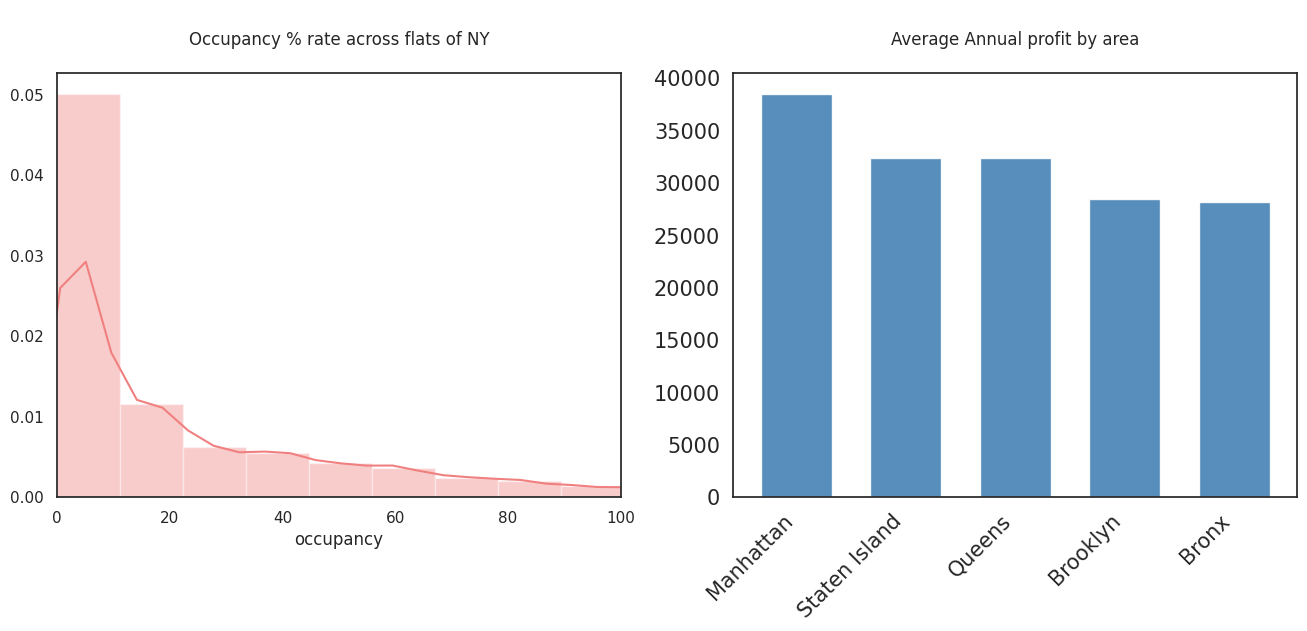

<Figure size 640x480 with 0 Axes>

In [0]:
fig = plt.figure(figsize=(16,5.5))
plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

a=sns.distplot(df["occupancy"],ax=ax1,rug=False, kde=True,color='lightcoral')
a.set(xlim=(0, 100))
ax1.set_title('\nOccupancy % rate across flats of NY\n')
b=df.groupby(["neighbourhood_group"])["annual_profit"].mean().sort_values(ascending=False).\
                                                      plot(kind="bar", alpha=0.9,width=0.65,fontsize=15,ax=ax2, 
                                                           title="Average Annual profit by area\n",color="steelblue")
ax2.set_xlabel('')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

sns.set(style="white")
plt.tight_layout()
plt.show()

In [0]:
df=df.drop(["annual_profit"],axis=1) #dropping annual_profit as we will no longer need them

# Correlation between features

It appears that there is not a strong correlation between price and most of the features of the dataset.

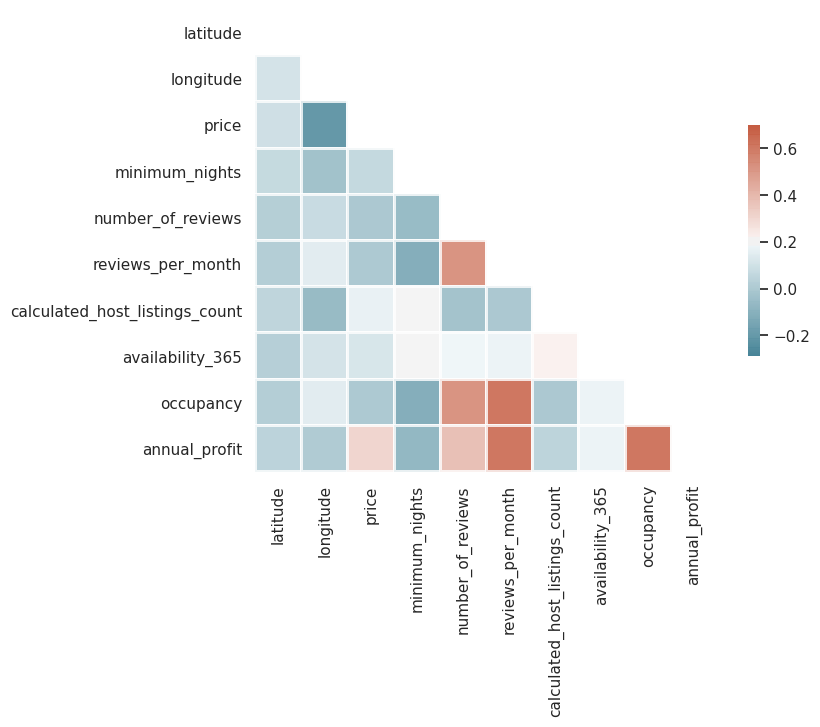

In [0]:
sns.set(style="white")
corrmatrix = df.drop("id",axis=1).corr()

# generate a mask for the upper triangle
mask = np.zeros_like(corrmatrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

f, ax = plt.subplots(figsize=(8,6))
sns.heatmap(corrmatrix, square=True,vmax=0.7,mask=mask, cmap=cmap,
            linewidths=1.5, cbar_kws={"shrink":.5},alpha=0.8)

plt.show()

# Adding extra information to the dataset

 

As it is highly likely that the price of a room is affected by its distance from famous places such as Times Square and Statue of Liberty, we will add an extra column consisting of the distance of each room from these places.

Coordinates:

**Times Square**:

*   Latitude: 40.758896
*   Longitude: -73.985130

**Statue of Liberty**:

*   Latitude: 40.689247
*   Longitude: -74.044502

**Central Park**:

*   Latitude: 40.785091
*   Longitude: -73.968285

**Empire State Building**:

*   Latitude: 40.748817
*   Longitude: -73.985428

**Rockefeller Center**:

*   Latitude: 40.758740
*   Longitude: -73.978674


In [0]:
df['distance']=np.sqrt(np.square(df.latitude-40.689247)+np.square(df.longitude+74.044502))+\
               np.sqrt(np.square(df.latitude-40.758896)+np.square(df.longitude+73.985130))+\
               np.sqrt(np.square(df.latitude-40.785091)+np.square(df.longitude+73.968285))+\
               np.sqrt(np.square(df.latitude-40.748817)+np.square(df.longitude+73.985428))+\
               np.sqrt(np.square(df.latitude-40.758740)+np.square(df.longitude+73.978674))

From the below map we can see that there is definitely an inverse relation between distance and price.

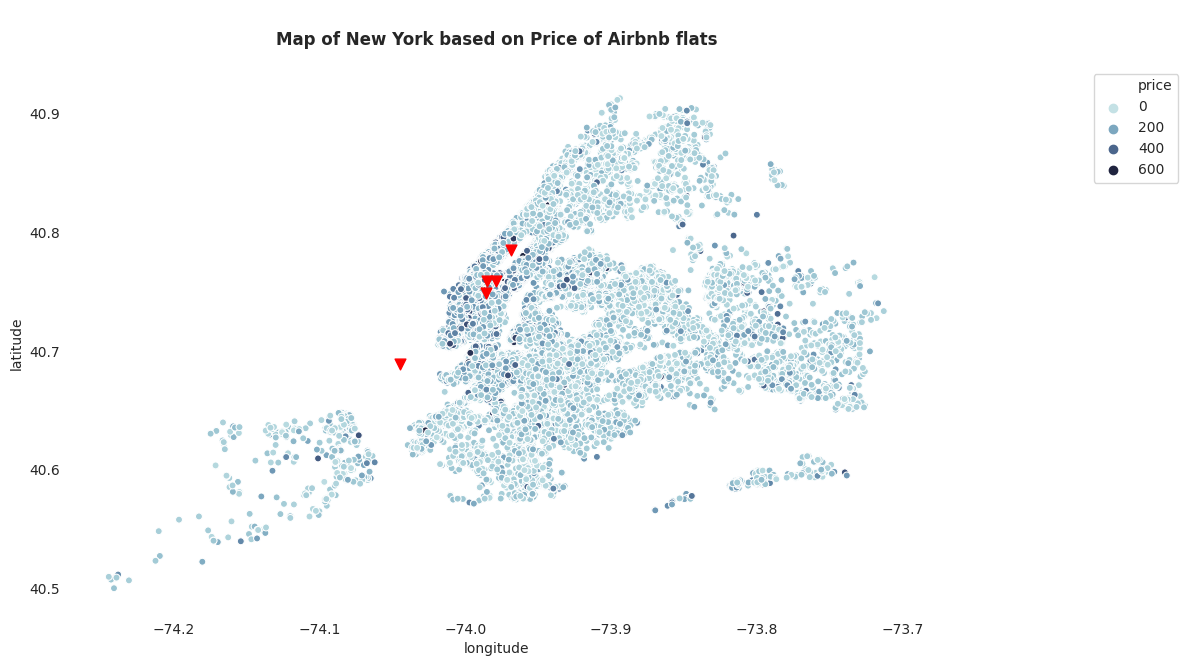

In [15]:
sns.set_style("white")
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
fig, ax = plt.subplots(figsize=(11,7))

# draw scatter plot
ax = sns.scatterplot(x="longitude", y="latitude",s=25,
                     hue='price', palette=cmap,  data=df)
ax.legend(bbox_to_anchor=(1.3, 1), borderaxespad=0.)
plt.title('\nMap of New York based on Price of Airbnb flats\n', fontsize=12, fontweight='bold')
plt.scatter(x=-74.044502,y=40.689247,c='r',marker='v',s=60) #statue of liberty
plt.scatter(x=-73.985130,y=40.758896,c='r',marker='v',s=60) #times square
plt.scatter(x=-73.968285,y=40.785091,c='r',marker='v',s=60) #central park
plt.scatter(x=-73.985428,y=40.748817,c='r',marker='v',s=60) #empire state building
plt.scatter(x=-73.978674,y=40.758740,c='r',marker='v',s=60) #rockefeller center
# remove spines
sns.despine(ax=ax, top=True, right=True, left=True, bottom=True);

# Recommendation of similar flats

One of the two main tasks of the project was to build a recommendation system in order for the customers/visitors to be given recommendation of similar flats to stay in terms of price, type, area and quality (estimated by demand) of the flat. 

Algorithm approach we will be using is **K-means** clustering. This method of vector quantization, originally from signal processing, aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster.

K-Means is known to perform poorly on sparse data with many (hundreds) features. Proper **PCA** is crucial for the best performance of the algorithm. We chose

The K-Means runs 20 times (n_init) with different initial centers. Reason for this, is that although K-Means is guaranteed to converge , it may not converge to the right solution. By running the algorithm multiple times with differenent initializations we enusure a better solution.

**Elboy theorem**: We then plot the model's inertia (the mean squared error). It is  observed that three is the right number of clusters. We further check our choise of three clusters with the Silhuette score of K-Means.

**Silhuette score**: The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. By plotting the different scores for the same range of clusters, it is further proven that we chose the right number of clusters. For 3 clusters we get a silhuette score of 0.48.

In [0]:
df_for_clustering=df.drop(columns=["calculated_host_listings_count","id"],axis=1)
df_for_clustering=df_for_clustering[df_for_clustering["occupancy"]>5]

One-hot encoding categorical features and scaling the data

In [0]:
num,cat=categorical_numerical(df_for_clustering)

In [0]:
scaler = StandardScaler()
df_for_clustering=pd.get_dummies(data=df_for_clustering, columns=cat)
df_for_clustering_scaled = pd.DataFrame(scaler.fit_transform(df_for_clustering))

**PCA**

In [0]:
pca = PCA(0.95)
pca.fit(df_for_clustering)
pcafeatures_scaled = pca.transform(df_for_clustering)

We use the option that allows you to set the variance of the input that is supposed to be explained by the generated components. 

Typically, we want the explained variance to be between 95–99%. In this case we use a 95% variance.
From the Scikit-learn implementation, we can get the information about the explained variance and plot the cumulative variance.

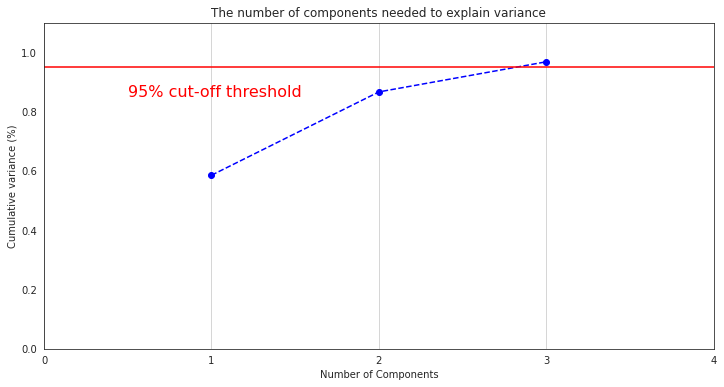

In [23]:
% matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 4, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 5, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [0]:
# Find optimum number of clusters with K-Means (takes aroound ten minutes)
k_range = range(2,10)
kmeans_scores = []
sse=[]

for k in k_range:
    km_ss = KMeans(n_clusters=k, random_state=1,n_init=20,max_iter=200)
    km_ss.fit(pcafeatures_scaled)
    kmeans_scores.append(silhouette_score(pcafeatures_scaled, km_ss.labels_))
    sse.append(km_ss.inertia_)

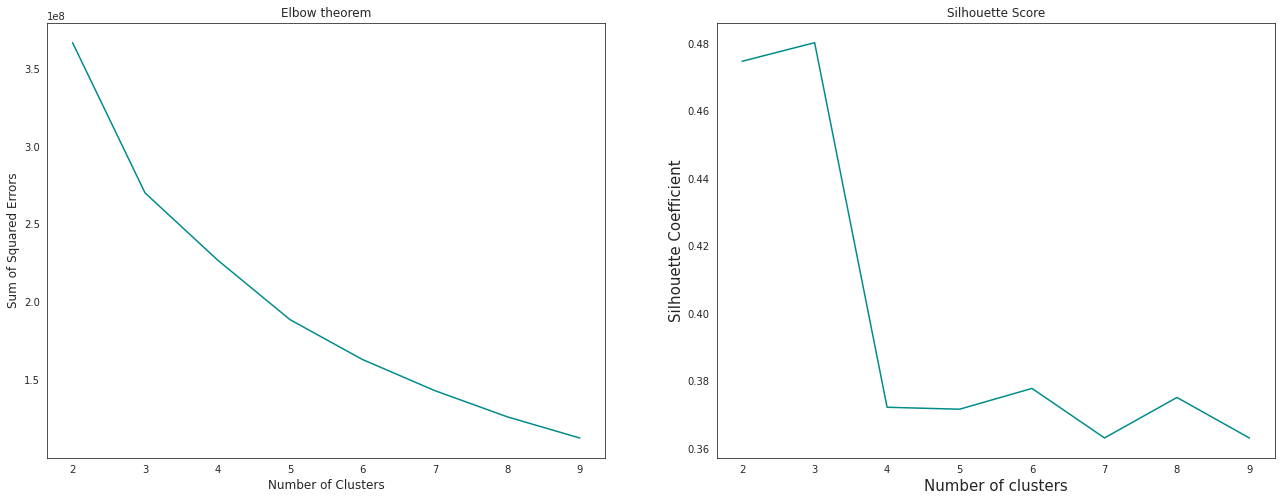

<Figure size 864x432 with 0 Axes>

In [29]:
fig = plt.figure(figsize=(22,8))
plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

#elbow theorem
ax1.set_ylabel('Sum of Squared Errors',fontsize=12)
ax1.set_xlabel('Number of Clusters',fontsize=12)
ax1.plot(k_range,sse,color="darkcyan")
ax1.title.set_text('Elbow theorem')

ax2.set_ylabel('Silhouette Coefficient',fontsize=15)
ax2.set_xlabel('Number of clusters',fontsize=15)
ax2.plot(k_range, kmeans_scores,color="darkcyan")
ax2.title.set_text('Silhouette Score')

plt.show()

In [27]:
k = 3
km_3 = KMeans(n_clusters=k, random_state=1,n_init=20,max_iter=400)
km_3.fit(pcafeatures_scaled);
print('Silhouette score for {} clusters = {}'.format(k,silhouette_score(pcafeatures_scaled, km_3.labels_)))

Silhouette score for 3 clusters = 0.48021179577717266


#Pricing optimization - ML pipeline

Main challenge of this project was to develop a pricing tool that can suggest a price (or a price range) to hosts. It is important in order for this process to be meaningful, to exclude highly overpriced flats (have already trimmed values over $500) and exclude from the dataset logins of flats with very low occupancy. Underlying idea is that we want to suggest a price based on active and successful hosts, not on "ghost-flats" that would add noise to our ML models, in order to optimize hosts profit.

Technical process that takes place, is excecuted in steps, as follows:


1.   We **examine under-represented categorical data**. More specifically, some of the categories of column "neighbourhood" consist of areas that have insufficient amount of indexes. It is very likely that our models "memorize" these indexes without any generalization value. For such indexes, we change the name of the area to "other" to bypass this issue.

2.   We thoroughly examine the target value "**price**". It appears that it has a very uneven distribution, skewed to the right. By taking the log of the "price" values, we observe a better distributed price and a boost in the overall ML models pipeline.

3.  We exlude "**ghost-flats**" that have a very low occupancy rate (less than 5%) as they will not provide any valuable information for our pricing recommendation algorithm.

Having established a solid dataset to use as input to the models, we create a "**Meta holdout scheme with OOF meta-features**" architecture. We use such implementation since although it looks complicated, it is computationally and time efficient:

1. We split train data into **K folds**. Iterating though each fold: retrain 3 diverse models on all folds except the current fold. We then predict for the current fold. 

2. After this step for each object in train_data we will have 3 meta-features (also known as out-of-fold predictions, OOF). Let's call them **meta_train_set**

3. We  predict for test data. Let's call these features **meta_test_set**.

4. Split meta_train_set into two parts: **train_metaA** and **train_metaB**. Fit a meta-model to **train_metaA** while validating its hyperparameters on **train_metaB**.

5. When the meta-model is validated, fit it to **train_meta** and predict for **test_meta**.


The three algorithms we will be using are: **Catboost**, **Light GBM** and **Random Forrest**. The meta-model is a second **Cat Boost Regressor**.

The selection of the models is made in a way to provide diversity to the predictions. As mentioned in "", we should search for models that "do not make the same mistakes". By having diverse models that make different mistakes, the meta-model is able to "learn" from these mistakes and provide a better than any of the individual models.



## Under-represented areas

One possible danger for the machine learning models we will deploy, is to overfit on neighborhoods where we do not have many indexes. By plotting indexes by neighborhood it will become clear if there is such issue.

In [0]:
df['freq'] = df.groupby('neighbourhood')['neighbourhood'].transform('count')

New feature "freq" counts the number of times an neighborhood has occured

In [32]:
df[(df['freq']<50)].neighbourhood.value_counts()

Port Morris        46
St. George         46
Allerton           42
Tompkinsville      42
Columbia St        41
                   ..
Lighthouse Hill     2
Richmondtown        1
New Dorp            1
Willowbrook         1
Rossville           1
Name: neighbourhood, Length: 121, dtype: int64

It appears that 121 neighborhoods are extremely under represented. In order to not overfit on their indexes we will transform these areas into "Other".

In [0]:
df.loc[df["freq"]<50, "neighbourhood"]="Other"

In [0]:
df=df.drop("freq",axis=1)

## Price

Two main points about the target column which is price:



1.   Price has 11 indices as zero. These logins do not provide any meaningful information; hence, they will not be a meaningful input to the ML models. We prefer to drop these values
2.   Price density plot shows a skew to the left side. In order to provide the best possible information to our ML models, it is advised to have a more equally distributed density of our target. This can easily be accomplished by taking the log values of the price.  





In [35]:
df[df['price']==0]["id"].count()

11

In [0]:
df = df.drop(df[df.price==0].index)

In [0]:
df['log_price'] = np.log(df['price'])

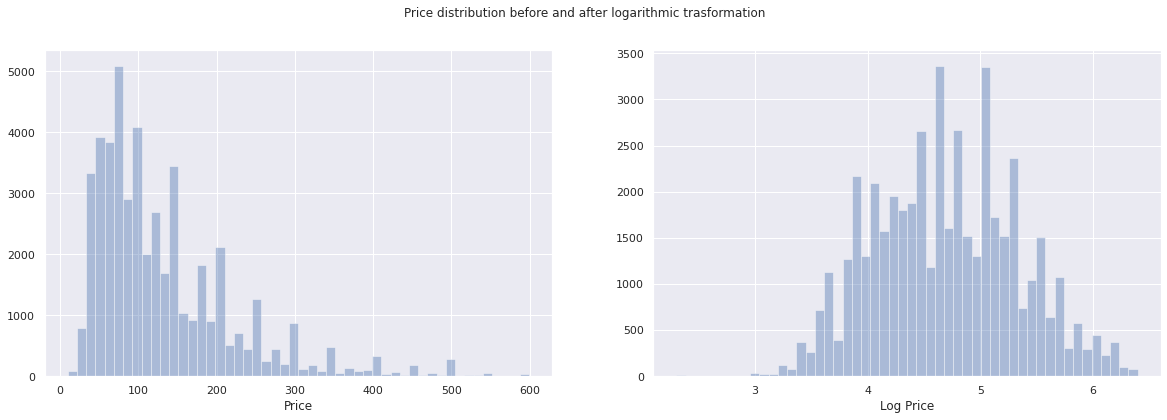

<Figure size 1440x720 with 0 Axes>

In [41]:
fig = plt.figure()
sns.set(rc={'figure.figsize':(20,6)})

# Divide the figure into a 2x1 grid, and give me the first section
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
plt.figure(figsize=(20,10))

sns.distplot(df["price"],ax=ax1,axlabel="Price",rug=False, kde=False)
sns.distplot(df["log_price"],ax=ax2,axlabel="Log Price",rug=False, kde=False)
fig.suptitle('Price distribution before and after logarithmic trasformation',fontsize=12)
plt.style.use("ggplot")
plt.show()

#Meta holdout scheme with OOF meta-features

Note: Train only on high demand logins

In [0]:
df1=df.copy()             #keep a copy (df1) of our original dataframe
df=df.drop("id",axis=1)
df=df[df["occupancy"]>5] #keep only active hosts to train our model

In [0]:
numerical,categorical=categorical_numerical(df)

Since we have categorical data in the dataset, we one-hot encode them before splitting into train and test set, otherwise we would end up with the test set having features (such as small neighbourhoods that did not happen to appear in the train set) that the model has not been trained on.

In [0]:
df=pd.get_dummies(data=df, columns=categorical)

Lets apply the memory reduction function in order to not bottleneck our ML models with unnecessary data size.

In [0]:
reduce_mem_usage(df)

Now lets create a test set that we will use only at the very end of the models pipeline to evaluate our process. Note that a Test set is different than the validation test which we will be using to validate training of the algorithms.

In [0]:
train, test_set = train_test_split(df, test_size=0.25)

In [0]:
X = train.drop(columns=['price','log_price'])
Y = train['log_price']

We will use X_train and Y_train for the K-folds by splitting it into 3 seperate groups and the X_test and Y_test as the "OOF" evaluation set

In [0]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X,Y,test_size = 0.25,random_state=42)

In [0]:
std_scaler = StandardScaler()
X_train_scaled=std_scaler.fit_transform(X_train)
X_test_scaled=std_scaler.transform(X_test)

##Level 1: **K-Folds training**

We create a custom function to cross-train on the K-folds and validate on the "out-of-fold" dataset.

In [0]:
def k_folds_training(n_splits, model):
    kf = KFold(n_splits,shuffle=False)
    kf.get_n_splits(X_train_scaled)
    outcomes = []
    for train_index, test_index in kf.split(X_train_scaled):
        Xtrain, Xtest = X_train_scaled[train_index], X_train_scaled[test_index]
        ytrain, ytest = Y_train.iloc[train_index], Y_train.iloc[test_index]
        model.fit(Xtrain, ytrain)
    preds = model.predict(X_test_scaled)
    preds_norm=np.exp(preds)
    Y_test_norm=np.exp(Y_test)
    lin_mae = mean_absolute_error(preds_norm, Y_test_norm)
    print('Mean Absolute Error on OOF:',lin_mae)

**LightGBoost**

In [0]:
d_train = lgb.Dataset(X_train_scaled, label=Y_train)
d_valid = lgb.Dataset(X_test_scaled, label=Y_test)

lgboost = lgb.LGBMRegressor(boosting_type= 'gbdt',
                            objective= 'regression',
                            max_depth= 8, 
                            learning_rate=0.1,
                            verbose= 0, 
                            metric= 'mae',
                            n_estimators= 1000)

**Catboost** Fine-tuning

In [0]:
catboost = CatBoostRegressor(task_type="GPU",devices='0:1')

grid = {'learning_rate': [0.06, 0.12,0.5],
        'depth': [1, 2, 5],
        'l2_leaf_reg': [0.01, 0.1, 0.5]}

# Grid search using the parameters in 'grid' variable. Find best model.
grid_search_result = catboost.grid_search(grid,
                                          X=X_train_scaled,
                                          y=Y_train,
                                          plot=True)

In [0]:
# Define a dictionary containing the best parameters resulting from grid search
params_dict = grid_search_result.get('params')
# Print the contents of the parameters dictionary
print(params_dict)
# Define variables containing the parameters from the dictionary
cb_depth = params_dict['depth']
cb_leaf_reg = params_dict['l2_leaf_reg']
cb_learning_rate = params_dict['learning_rate']

**Catboost** final hyperparameters

In [0]:
catboost = CatBoostRegressor(task_type="GPU",devices='0:1',iterations=500,
                             depth=2,
                             l2_leaf_reg=2,
                             learning_rate=0.1,
                             verbose=0)


**Random Forrest**

In [0]:
rf = RandomForestRegressor(random_state=0)

**Layer 1: training and predicting on validation set and creating meta-test set**

In [0]:
meta_train_set=pd.DataFrame()
meta_train_set["log_price"]=Y_test
X_test_set=test_set.drop(["price","log_price"],axis=1)        #creating a metatest set
X_test_set=std_scaler.fit_transform(X_test_set)
meta_test_set=pd.DataFrame()
meta_test_set["log_price"]=test_set['log_price']

Random Forrest (fit with K-Fold, predict and score on OOF, predict on test data)

In [0]:
k_folds_training(5,rf)       # K-Fold training for Random Forrest and mae score on OOF (validation set)

Mean Absolute Error on OOF: 36.750343158303444


In [0]:
meta_train_set["preds_randomforrest"]=rf.predict(X_test_scaled)

In [0]:
meta_test_set["preds_randomforrest"]=rf.predict(X_test_set)

Light GBM (fit with K-Fold, predict and score on OOF, predict on test data)

In [0]:
k_folds_training(5, lgboost)   # K-Fold training for LightXGB and mae score on OOF (validation set)

Mean Absolute Error on OOF: 38.39571457806358


In [0]:
meta_train_set["preds_lgb"]=lgboost.predict(X_test_scaled)

In [0]:
meta_test_set["preds_lgb"]=lgboost.predict(X_test_set)

CatBoost (fit with K-Fold, predict and score on OOF, predict on test data)

In [0]:
k_folds_training(5, catboost)   # K-Fold training for CatBoost and mae score on OOF (validation set)

Mean Absolute Error on OOF: 37.33504712815978


In [0]:
meta_train_set["preds_catboost"]=catboost.predict(X_test_scaled)

In [0]:
meta_test_set["preds_catboost"]=catboost.predict(X_test_set)

Having a view on the meta train set

In [0]:
meta_train_set

,log_price,preds_randomforrest,preds_lgb,preds_catboost
18820,3.401197,4.078569,4.019736,3.890771
6994,5.117994,5.173526,5.095622,4.972950
44003,5.236442,5.567100,5.729973,5.637520
11514,3.912023,3.990530,4.015093,4.208174
35582,4.094345,4.516926,4.517322,4.311320
...,...,...,...,...
32251,4.595120,4.483042,4.568541,4.320754
20589,4.553877,4.731440,4.705019,4.699967
34137,4.077538,4.526564,4.653623,4.584188
33993,4.204693,4.464617,4.505706,4.550127


##**Level 2: meta-model training**

In [0]:
meta_train_set_X=meta_train_set.drop('log_price',axis=1)
meta_train_set_Y=meta_train_set['log_price']

In [0]:
A_meta_train_set_X, B_meta_train_set_X, A_meta_train_set_Y, B_meta_train_set_Y = sklearn.model_selection.train_test_split(meta_train_set_X,meta_train_set_Y,test_size = 0.25,random_state=42)

In [0]:
A_meta_train_set_X=std_scaler.fit_transform(A_meta_train_set_X)
B_meta_train_set_X=std_scaler.transform(B_meta_train_set_X)

In [0]:
metamodel = CatBoostRegressor(task_type="GPU",devices='0:1',iterations=500,
                             depth=2,
                             l2_leaf_reg=2,
                             learning_rate=0.1,
                             verbose=0)

In [0]:
metamodel.fit(A_meta_train_set_X,A_meta_train_set_Y)
preds=metamodel.predict(B_meta_train_set_X)

In [0]:
preds_norm=np.exp(preds)
Y_test_norm=np.exp(B_meta_train_set_Y)
lin_mae = mean_absolute_error(preds_norm, Y_test_norm)
print('Mean Absolute Error on OOF:',lin_mae)

Mean Absolute Error on OOF: 36.217037549831105


**Fit on the whole meta_train_set**

In [0]:
metamodel.fit(std_scaler.transform(meta_train_set_X),meta_train_set_Y)

##**Level 3: Predict on the meta_test_set**

In [0]:
meta_test_set_values=meta_test_set.drop(["log_price"],axis=1)

In [0]:
meta_test_set_values=std_scaler.transform(meta_test_set_values)

In [0]:
preds=metamodel.predict(meta_test_set_values)

In [0]:
preds_norm=np.exp(preds)
Y_test_norm=np.exp(meta_test_set['log_price'])
lin_mae = mean_absolute_error(preds_norm, Y_test_norm)
print('Final Mean Average Error on test data:',lin_mae)

Final Mean Average Error on test: 37.656612221200774
